In [1]:
import copy
import math
import itertools
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.linear_model import LinearRegression
from IPython.display import Markdown, display
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

In [2]:
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf');

font = matplotlib.font_manager.FontProperties(fname='/System/Library/Fonts/Supplemental/Avenir.ttf')

## Simulating allele frequency dynamics

In [3]:
# here's the setup:
# diploid w/ one locus, four alleles: 0 (sensitive), 1, 2, 3 (resistant); 
# there are three environments, and fitnesses and dominance coefficients are different in different environments;
# we are assuming that the effects of mutation, recombination, and drift are negligible over the time scales considered;
# we further assume that resistant heterozygotes are codomimant (such that the fitness of e.g. 23 is the avg. of 22 and 33)

In [4]:
alleles = [0, 1, 2, 3] # sensitive and resistant alleles w/ one, two, and three mutations, respectively
genotypes = ['00', '01', '02', '03', '11', '12', '13', '22', '23', '33'] # allele combinations

# to parse out data:
alleles_dict = {0: 'IGFG', 1: 'VGFG', 2: 'VGFA', 3: 'VAYG'} # haplotype names to alleles notation mapping
genotypes_dict = dict(zip(genotypes, ['SS', 'SR1', 'SR2', 'SR3', 'R1R1', 'R1R2', 'R1R3', 'R2R2', 'R2R3', 'R3R3'])) # Marianna's notation

In [5]:
# ploting parameters:
grey = '#999999' 
blue = '#274060' # untreated cages
orange = '#ffa500' # treated cages
allele_colors = {0: '#30a4bc', 1: '#ffce1b', 2: '#ec4176', 3: '#782e6e'} 
w = 2 # linewidth 
fontsize = 12 # font size
padsize = 12 # pad size
legendfontsize = 10 # legend font size

display(Markdown('<br>'.join(
    f'<span style="font-family: monospace">{color} <span style="color: {color}">████████</span></span>'
    for color in [orange, blue] + list(allele_colors.values())
)))

<span style="font-family: monospace">#ffa500 <span style="color: #ffa500">████████</span></span><br><span style="font-family: monospace">#274060 <span style="color: #274060">████████</span></span><br><span style="font-family: monospace">#30a4bc <span style="color: #30a4bc">████████</span></span><br><span style="font-family: monospace">#ffce1b <span style="color: #ffce1b">████████</span></span><br><span style="font-family: monospace">#ec4176 <span style="color: #ec4176">████████</span></span><br><span style="font-family: monospace">#782e6e <span style="color: #782e6e">████████</span></span>

In [6]:
def add_white(hex_color: str, percent_white: float) -> str:
    
    r = int(hex_color.lstrip('#')[0:2], 16)
    g = int(hex_color.lstrip('#')[2:4], 16) 
    b = int(hex_color.lstrip('#')[4:6], 16)
    
    r_whiter = round(r + (255 - r) * (percent_white / 100))
    g_whiter = round(g + (255 - g) * (percent_white / 100))
    b_whiter = round(b + (255 - b) * (percent_white / 100))
    
    return '#{:02X}{:02X}{:02X}'.format(r_whiter, g_whiter, b_whiter)

In [7]:
# getting the relative viabilities, always relative to 00
def get_w(s0, s1, s2, s3, h01, h02, h03):
    
    return {'00': 1, 
            '11': 1 + s1,
            '22': 1 + s2,
            '33': 1 + s3,
            '01': 1 + h01 * s1,
            '02': 1 + h02 * s2,
            '03': 1 + h03 * s3,
            '12': 1 + 0.5 * (s1 + s2),
            '13': 1 + 0.5 * (s1 + s3),
            '23': 1 + 0.5 * (s2 + s3)}

# getting h and s, always relative to 00
# note that we will replace all 0 viabilities w/ 0.01 
# so that we can use the chosen parametrization when we need to

def get_h_s(w_dict): # note that it does not matter whether w_dict contains relative or absolute viabilities
                     # since we'll normalize that out
        
    w_dict_non0 = {x: max(0.01, y) for x, y in w_dict.items()}
    
    s0 = 0
    s1 = w_dict_non0['11'] / w_dict_non0['00'] - 1
    s2 = w_dict_non0['22'] / w_dict_non0['00'] - 1
    s3 = w_dict_non0['33'] / w_dict_non0['00'] - 1
    
    hs = []
    for c, i in enumerate([s1, s2, s3]):
        if i == 0:
            hs.append(1/2) # it does not matter, could be anything
        else:
            hs.append((w_dict_non0['00'] - w_dict_non0['0' + str(c + 1)]) / (w_dict_non0['00'] - w_dict_non0[str(c + 1) + str(c + 1)]))
     
    return {'s0': s0,
            's1': s1,
            's2': s2,
            's3': s3,
            'h01': hs[0],
            'h02': hs[1],
            'h03': hs[2]}

In [8]:
# running the viability selection model as parametrized above
def simulate_allele_fs(fs_0, w, T, genotype_fs_0=None):
    
    """Runs simulations in the no-drug environment, 
       where any genotype with two resistant alleles carries a fitness cost s.
    
    args:    
        fs: initial allele frequencies
             type: a dictionary w/ alleles as keys and lists of frequencies as values
             e.g.: {0: [1], 1: [0], 2: [0], 3: [0]}
        w: relative or absolute viabilities,
            type: dict w/ genotypes as keys 
            e.g. w_dict in get_w
        T: number of generations
            type: int
            e.g.: 10
        
    returns: allele and genotype frequencies throughout time
             type: a dictionary w/ alleles or genotypes as keys and lists of frequencies as values
             e.g. {0: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 3: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
    """
    
    # if the initial genotype frequencies are not known, assume Hardy-Weinberg:
    if genotype_fs_0 == None:
        genotype_fs = {}
        for i in ['00', '01', '02', '03', '11', '12', '13', '22', '23', '33']:
            if len(set(i)) == 1:
                genotype_fs[i] = [fs_0[int(i[0])][0]**2]
            else:
                genotype_fs[i] = [2*fs_0[int(i[0])][0]*fs_0[int(i[1])][0]]
    else:
        genotype_fs = copy.deepcopy(genotype_fs_0)
            
    fs = copy.deepcopy(fs_0)
    
    for t in range(0, T - 1):
        
        denom = fs[0][t]**2*w['00'] + 2*fs[0][t]*fs[1][t]*w['01'] + 2*fs[0][t]*fs[2][t]*w['02'] + 2*fs[0][t]*fs[3][t]*w['03'] + \
                fs[1][t]**2*w['11'] + 2*fs[1][t]*fs[2][t]*w['12'] + 2*fs[1][t]*fs[3][t]*w['13'] + \
                fs[2][t]**2*w['22'] + 2*fs[2][t]*fs[3][t]*w['23'] + \
                fs[3][t]**2*w['33']

        nums = {0: fs[0][t]**2*w['00'] + fs[0][t]*fs[1][t]*w['01'] + fs[0][t]*fs[2][t]*w['02'] + fs[0][t]*fs[3][t]*w['03'],
                1: fs[0][t]*fs[1][t]*w['01'] + fs[1][t]**2*w['11'] + fs[1][t]*fs[2][t]*w['12'] + fs[1][t]*fs[3][t]*w['13'],
                2: fs[0][t]*fs[2][t]*w['02'] + fs[1][t]*fs[2][t]*w['12'] + fs[2][t]**2*w['22'] + fs[2][t]*fs[3][t]*w['23'],
                3: fs[0][t]*fs[3][t]*w['03'] + fs[1][t]*fs[3][t]*w['13'] + fs[2][t]*fs[3][t]*w['23'] + fs[3][t]**2*w['33']}
        
        for i in alleles:
            fs[i].append(nums[i] / denom)
             
        genotype_fs['00'].append(fs[0][t]**2*w['00'] / denom)
        genotype_fs['01'].append(2*fs[0][t]*fs[1][t]*w['01'] / denom)
        genotype_fs['02'].append(2*fs[0][t]*fs[2][t]*w['02'] / denom)
        genotype_fs['03'].append(2*fs[0][t]*fs[3][t]*w['03'] / denom)
        genotype_fs['11'].append(fs[1][t]**2*w['11'] / denom)
        genotype_fs['12'].append(2*fs[1][t]*fs[2][t]*w['12'] / denom)
        genotype_fs['13'].append(2*fs[1][t]*fs[3][t]*w['13'] / denom)
        genotype_fs['22'].append(fs[2][t]**2*w['22'] / denom)
        genotype_fs['23'].append(2*fs[2][t]*fs[3][t]*w['23'] / denom)
        genotype_fs['33'].append(fs[3][t]**2*w['33'] / denom)
    
    return fs, genotype_fs

#### Downloading experimental data

In [9]:
# retreiving appropriate parameter values:
# need to know initial frequencies, selection/dominance coefficients, Ts

# data provided by Marianna
allele_freqs = pd.read_csv('../data/haplotype_freqs.csv') 

dates = sorted(list(set(allele_freqs['Date'])))

# see ../code/degree_day_model.Rmd
date_generation_dose = pd.read_csv('../data/generation_start_July13.csv') 

date_generation_dose_dict = {}
for i in dates:
    for j in range(len(date_generation_dose)):
        if date_generation_dose['Date'][j] == i:
            date_generation_dose_dict[i] = [date_generation_dose['generation'][j] - 1, date_generation_dose['dose_ppm'][j]]

# adding the last timepoint:
date_generation_dose_dict[dates[-1]] = [10, 0.0]

# w/ pesticide
allele_freqs_dates = allele_freqs[(allele_freqs['Date'].isin(dates)) & (allele_freqs['treatment'] == 'P')]
allele_freqs_dates.loc[:, 'cage'] = allele_freqs_dates['cage'].apply(lambda x: int(x[1:]))
avg_allele_freqs = {}
for i in alleles:
    avg_allele_freqs[i] = []
    for j in dates: 
        freqs = allele_freqs_dates[(allele_freqs_dates['haplotype_class'] == alleles_dict[i]) & (allele_freqs_dates['Date'] == j)]['frequency']
        avg_allele_freqs[i].append([date_generation_dose_dict[j][0], np.median(freqs), np.percentile(freqs, 25), np.percentile(freqs, 75)])
        
# no pesticide
allele_freqs_control_dates = allele_freqs[(allele_freqs['Date'].isin(dates)) & (allele_freqs['treatment'] == 'E')]
allele_freqs_control_dates.loc[:, 'cage'] = allele_freqs_control_dates['cage'].apply(lambda x: int(x[1:]))
avg_allele_freqs_control = {}
allele_trj_control = []
for i in alleles:
    avg_allele_freqs_control[i] = []
    for j in dates: 
        freqs = allele_freqs_control_dates[(allele_freqs_control_dates['haplotype_class'] == alleles_dict[i]) & (allele_freqs_control_dates['Date'] == j)]['frequency']
        avg_allele_freqs_control[i].append([date_generation_dose_dict[j][0], np.median(freqs), np.percentile(freqs, 25), np.percentile(freqs, 75)])
        

In [10]:
# replacing direct lab measurments w/ values from fitted curves (by Marianna) by Marianna's request
simulated_viabilities = pd.read_csv('../data/viability_values_simulations.csv')
simulated_viabilities['genotypes'] = simulated_viabilities['genotypes'].apply(lambda x: f'{x:02}')

simulated_viabilities_dict = simulated_viabilities.groupby('conc').apply(lambda x: dict(zip(x['genotypes'], x['viabilities']))).to_dict()

viabilities = {}
for c, d in simulated_viabilities_dict.items():
    viabilities[c] = d
        


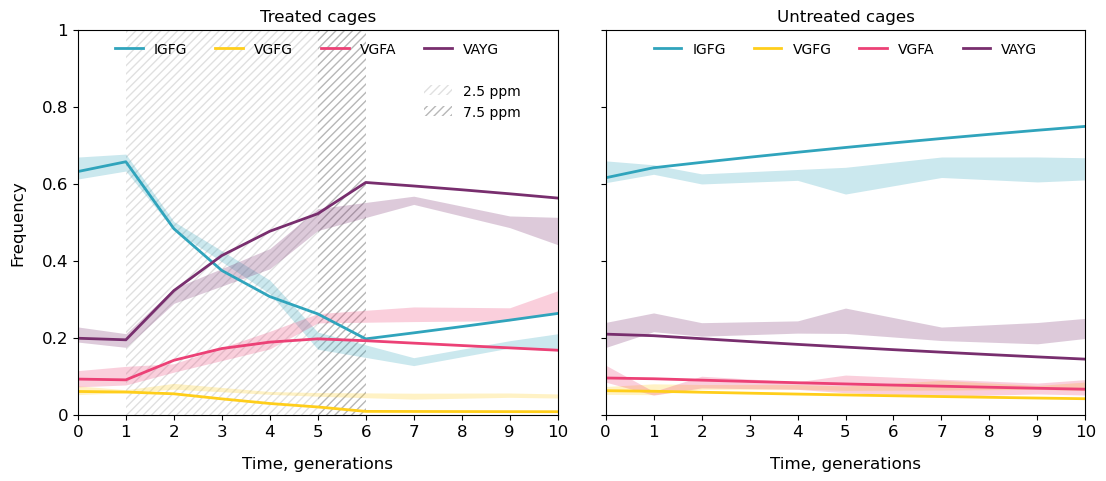

In [11]:
# running simulations & plotting the results: 
fig = plt.figure(figsize=(13, 5))

grid = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[1, 1], wspace=0.1,
                         height_ratios=[1], hspace=0)

# how many generations in each environment (+1 generation for the initial timepoint)
t1 = 1 + 1
t2 = 4 + 1
t3 = 1 + 1
t4 = 4 + 1
t = t1 + t2 + t3 + t4 - 4

for c in range(2):
    
    plt.subplot(grid[c // 2, c % 2])
    
    if c == 0: # left panel
    
        plt.fill_between([t1 - 1, t1 - 1 + t2 - 1], [1, 1], facecolor='#ffffff', edgecolor=grey, linewidth=0, alpha=0.3, hatch='////', label='2.5 ppm')
        plt.fill_between([t1 - 1 + t2 - 1, t1 - 1 + t2 - 1 + t3 - 1], [1, 1], facecolor='#ffffff', edgecolor=grey, linewidth=0, alpha=0.7, hatch='////', label='7.5 ppm')

        # simulating the experiment:
        fs_1, gen_fs_1 = simulate_allele_fs({x: [avg_allele_freqs[x][0][1]] for x in alleles}, viabilities[0.0], t1)
        fs_2, gen_fs_2 = simulate_allele_fs({x: [fs_1[x][-1]] for x in alleles}, viabilities[2.5], t2, {x: [gen_fs_1[x][-1]] for x in genotypes})
        fs_3, gen_fs_3 = simulate_allele_fs({x: [fs_2[x][-1]] for x in alleles}, viabilities[7.5], t3, {x: [gen_fs_2[x][-1]] for x in genotypes})
        fs_4, gen_fs_4 = simulate_allele_fs({x: [fs_3[x][-1]] for x in alleles}, viabilities[0.0], t4 + 1, {x: [gen_fs_3[x][-1]] for x in genotypes})

        # merging all frequencies:
        fs = {x: fs_1[x] + fs_2[x][1:] + fs_3[x][1:] + fs_4[x][1:] for x in alleles}
        gen_fs = {x: gen_fs_1[x] + gen_fs_2[x][1:] + gen_fs_3[x][1:] + gen_fs_4[x][1:] for x in genotypes}
        
        # checking that genotype frequencies give the right allele frequencies:
        for i in range(t):
            for j in alleles:
                f = sum([0.5 * gen_fs[x][i] for x in genotypes if len(set(x)) == 2 and str(j) in x]) + gen_fs[str(j) + str(j)][i]
                if (fs[j][i] - f) / fs[j][i] > 0.01: # if the error is more than 0.01
                    if i > 0: # the first generations should be off since we have assumed Hardy-Weinberg
                        print(i)
        
        # saving the output - uncomment this part if needed
        sim_allele_freqs_pest = pd.DataFrame(columns=['allele', 't=0', 't=1', 't=2', 't=3', 't=4', 't=5', 't=6', 't=7', 't=8', 't=9', 't=10'])
        for i in alleles:
            sim_allele_freqs_pest.loc[len(sim_allele_freqs_pest.index)] = [alleles_dict[i]] + fs[i][:-1]
            sim_allele_freqs_pest.to_csv('../data/sim_allele_freqs_treated_cages.csv', index=False) 

        for i in alleles:
            plt.plot(range(0, t + 2), fs[i], color=allele_colors[i], label=alleles_dict[i], linewidth=w)
            plt.fill_between(x=[x[0] for x in avg_allele_freqs[i]], y1=[x[2] for x in avg_allele_freqs[i]], y2=[x[3] for x in avg_allele_freqs[i]], 
                             color=allele_colors[i], alpha=0.25, linewidth=0, zorder=1)
  
        plt.title('Treated cages', fontsize=fontsize)
    
        # some fake points w/ labels to help arrange legend labels
        for i in range(10):
            plt.scatter(-1, -1, alpha=0, label=' ')
    
        handles, labels = plt.gca().get_legend_handles_labels()
        order = [2, 6, 7, 8, 3, 9, 10, 11, 4, 12, 13, 14, 5, 15, 0, 1]
        plt.legend([handles[i] for i in order], [labels[i] for i in order],
                   frameon=False, fontsize=legendfontsize, loc='upper center', handletextpad=0.8, ncol=4)
        
    elif c == 1: # right panel
        # now, simulating the experiment with no pesticide:
        fs_control, gen_fs_control = simulate_allele_fs({x: [avg_allele_freqs_control[x][0][1]] for x in alleles}, viabilities[0.0], t + 2)

        # checking that genotype frequencies give the right allele frequencies:
        for i in range(t):
            for j in alleles:
                f = sum([0.5 * gen_fs[x][i] for x in genotypes if len(set(x)) == 2 and str(j) in x]) + gen_fs[str(j) + str(j)][i]
                if (fs[j][i] - f) / fs[j][i] > 0.01: # if the error is more than 0.01
                    if i > 0: # the first generations should be off since we have assumed Hardy-Weinberg
                        print(i)

        # saving the output - uncomment if needed
        sim_allele_freqs_control = pd.DataFrame(columns=['allele', 't=0', 't=1', 't=2', 't=3', 't=4', 't=5', 't=6', 't=7', 't=8', 't=9', 't=10'])
        for i in alleles:
            sim_allele_freqs_control.loc[len(sim_allele_freqs_control.index)] = [alleles_dict[i]] + fs_control[i][:-1]
            sim_allele_freqs_control.to_csv('../data/sim_allele_freqs_untreated_cages.csv', index=False) 
            
        for i in alleles:
            plt.plot(range(t + 2), fs_control[i], color=allele_colors[i], label=alleles_dict[i], linewidth=w)
            plt.fill_between(x=[x[0] for x in avg_allele_freqs_control[i]], y1=[x[2] for x in avg_allele_freqs_control[i]], y2=[x[3] for x in avg_allele_freqs_control[i]], 
                             color=allele_colors[i], alpha=0.25, linewidth=0, zorder=0)
            
        plt.title('Untreated cages', fontsize=fontsize)
        
        plt.legend(frameon=False, fontsize=legendfontsize, loc='upper center', handletextpad=0.8, ncol=4);
    
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    plt.tick_params(axis='both', labelsize=fontsize)

    plt.ylim(0, 1)
    plt.xlim(0, 10)
    
    if c == 0:
        plt.ylabel('Frequency', fontsize=fontsize, labelpad=padsize);
        plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    else:
        plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], [])
    plt.xlabel('Time, generations', fontsize=fontsize, labelpad=padsize);  
    

plt.savefig('../figures/simulated_allele_freqs.pdf', dpi=600, bbox_inches='tight') 

In [12]:
# let's now estimate h and s from viability measurements using the definitions above:
# can check that if we use these values, we'll get the viabilities back - done! at 7.5 ppm, cannot find h01 since s1 = s0
h_s_dict = {0.0: get_h_s(viabilities[0.0]),
            2.5: get_h_s(viabilities[2.5]),
            7.5: get_h_s(viabilities[7.5])} # we had to assume that not all sensitive flies die at this conc, so the numbers might be off

In [13]:
h_s_dict[0]

{'s0': 0,
 's1': -0.1460674157303371,
 's2': -0.1685393258426966,
 's3': -0.1235955056179775,
 'h01': 0.23076923076923098,
 'h02': 0.13333333333333344,
 'h03': 0.272727272727273}

## Simulating population resistance 

In [ ]:
# calculating resistance in the population as a weighted sum
def calculate_resistance_in_pop(gen_fs, gen_rs): # takes two dictionaries with genotypes as keys
    resistance = 0 
    for i in genotypes:
        resistance += gen_rs[i] * gen_fs[i]
    return resistance

In [15]:
# reading resistance data provided by Marianna
resistance_data = pd.read_csv('../data/resistance_cage.csv') # so that the dates match across files
resistance_data = resistance_data.replace('2021-08-25', '2021-08-24')
conc = [0.0, 2.5, 5.0, 7.5, 10.0, 15.0]

resistance_t_pesticide = {}
for j in date_generation_dose_dict.keys():
    resistance_t_pesticide[j] = []
    for k in conc:
        resistance_t_pesticide[j].append([np.median([resistance_data['mean_Survival'][i] for i in range(len(resistance_data)) 
                                          if resistance_data['Treatment'][i] == 'P' and 
                                          resistance_data['Date'][i] == j and 
                                          resistance_data['Dose_ppm'][i] == k]),
                                          np.std([resistance_data['mean_Survival'][i] for i in range(len(resistance_data)) 
                                          if resistance_data['Treatment'][i] == 'P' and 
                                          resistance_data['Date'][i] == j and 
                                          resistance_data['Dose_ppm'][i] == k])])

resistance_t_control = {}
for j in date_generation_dose_dict.keys():
    resistance_t_control[j] = []
    for k in conc:
        resistance_t_control[j].append([np.median([resistance_data['mean_Survival'][i] for i in range(len(resistance_data)) 
                                        if resistance_data['Treatment'][i] == 'E' and 
                                        resistance_data['Date'][i] == j and 
                                        resistance_data['Dose_ppm'][i] == k]),
                                        np.std([resistance_data['mean_Survival'][i] for i in range(len(resistance_data)) 
                                        if resistance_data['Treatment'][i] == 'E' and 
                                        resistance_data['Date'][i] == j and 
                                        resistance_data['Dose_ppm'][i] == k])])


/Users/alyulina/Software/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/alyulina/Software/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/alyulina/Software/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/alyulina/Software/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/alyulina/Software/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


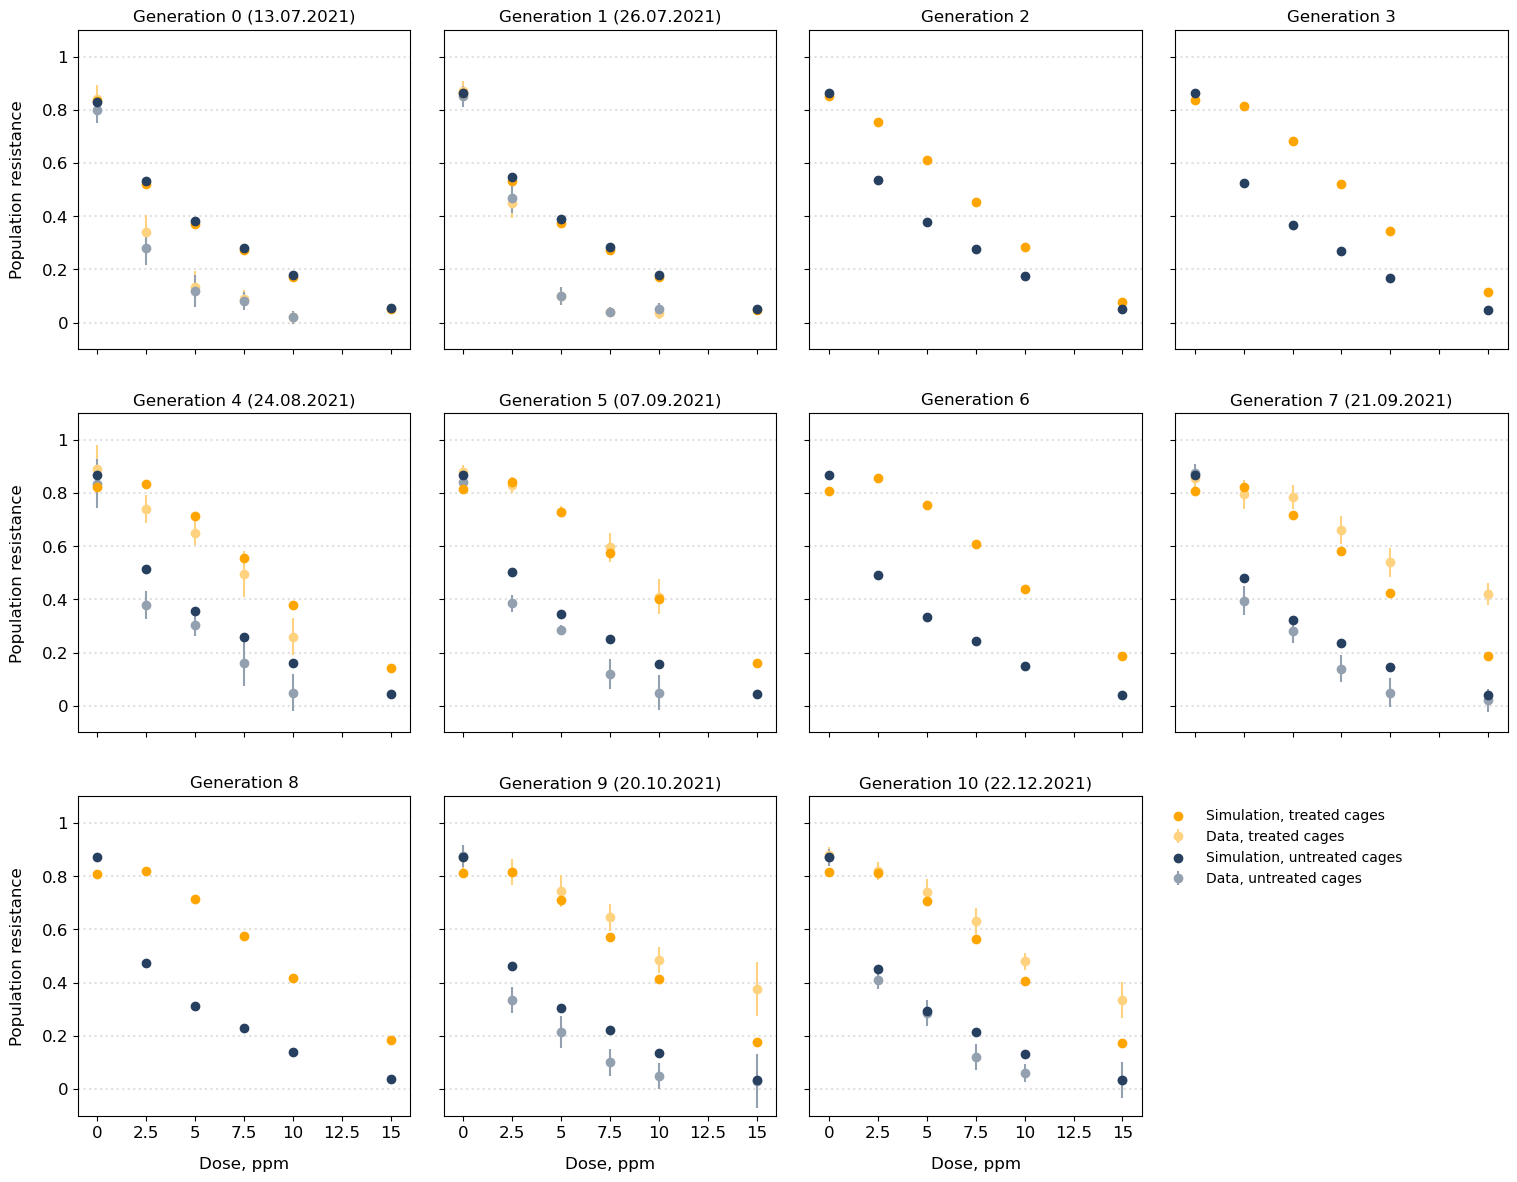

In [16]:
# saving simulated pop. resistances
sim_resistance_data = pd.DataFrame(columns=['resistance', 'environment', 'drug conc.', 'date', 'gen.'])

fig = plt.figure(figsize=((3*4+0.1*3)*3/2, (3*3+0.2*2)*3/2))

grid = gridspec.GridSpec(ncols=4, nrows=3,
                         width_ratios=[1, 1, 1, 1], wspace=0.1,
                         height_ratios=[1, 1, 1], hspace=0.2)

dates_to_plot = ['2021-07-13', '2021-07-26', '2021-08-24', '2021-09-07', '2021-09-21', '2021-10-20', '2021-12-22']

for i in range(0, 11):
    plt.subplot(grid[i // 4, i % 4])   
    
    gen_fs_g = {x: gen_fs[x][i] for x in genotypes}
    gen_fs_g_control = {x: gen_fs_control[x][i] for x in genotypes}
            
    for j, dose in enumerate(conc):
        resistance_pop_g = calculate_resistance_in_pop(gen_fs_g, viabilities[dose])
        resistance_pop_g_control = calculate_resistance_in_pop(gen_fs_g_control, viabilities[dose])

        plt.scatter(dose, resistance_pop_g, marker='o', color=orange, zorder=4)
        plt.scatter(dose, resistance_pop_g_control, marker='o', color=blue, zorder=4)

        sim_resistance_data.loc[len(sim_resistance_data.index)] = [resistance_pop_g, 'pesticide', dose, '', i]  
        sim_resistance_data.loc[len(sim_resistance_data.index)] = [resistance_pop_g_control, 'control', dose, '', i]  
            
        plt.title('Generation ' + "{:.0f}".format(i), fontsize=fontsize)
        
    for date in dates_to_plot:
        if int(date_generation_dose_dict[date][0]) == i:
            
            for j, dose in enumerate(conc):
                resistance_pesticide = resistance_t_pesticide[date][j]
                resistance_control = resistance_t_control[date][j]

                if not np.isnan(resistance_pesticide[0]) and not np.isnan(resistance_pesticide[1]):
                    plt.errorbar(x=dose, y=resistance_pesticide[0] / 100, yerr=resistance_pesticide[1] / 100, 
                                 fmt='o', color=add_white(orange, 50))
    
                if not np.isnan(resistance_control[0]) and not np.isnan(resistance_control[1]):
                    plt.errorbar(x=dose, y=resistance_control[0] / 100, yerr=resistance_pesticide[1] / 100, 
                                 fmt='o', color=add_white(blue, 50))

            plt.title('Generation ' + "{:.0f}".format(i) + ' (' + date[-2:] + '.' + date[-5:-3] + '.' + date[:4] + ')', fontsize=fontsize)

    if i == 10: # this is just for the legend
        plt.errorbar(x=-1, y=-1, yerr=0.5, fmt='o', color=add_white(orange, 50), label='Data, treated cages')
        plt.scatter(-1, -1, marker='o', color=orange, label='Simulation, treated cages')

        plt.errorbar(x=-1, y=-1, yerr=0.5, fmt='o', color=add_white(blue, 50), label='Data, untreated cages')
        plt.scatter(-1, -1, marker='o', color=blue, label='Simulation, untreated cages')
        
        handles, labels = plt.gca().get_legend_handles_labels()
        order = [0, 2, 1, 3]
        plt.legend([handles[i] for i in order], [labels[i] for i in order],
                   frameon=False, fontsize=legendfontsize, loc='upper right', bbox_to_anchor=(1.82, 1.0, 0.0, 0.0), handletextpad=1)
    
    plt.hlines([0, 0.2, 0.4, 0.6, 0.8, 1], -1, 16, zorder=-1, color=grey, alpha=0.3, linestyle=':')
       
    plt.tick_params(axis='both', labelsize=fontsize)
    
    plt.ylim(-0.1, 1.1)
    plt.xlim(-1, 16)
    
    if i % 4 == 0: 
        plt.ylabel('Population resistance', fontsize=fontsize, labelpad=padsize)
        plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 0.2, 0.4, 0.6, 0.8, 1])
        
    else:
        plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], [])
        
    if i // 4 == 2:
        plt.xlabel('Dose, ppm', fontsize=fontsize, labelpad=padsize) 
        plt.xticks([0, 2.5, 5, 7.5, 10, 12.5, 15], [0, 2.5, 5, 7.5, 10, 12.5, 15])
    
    else:
        plt.xticks([0, 2.5, 5, 7.5, 10, 12.5, 15], [])
        
sim_resistance_data.to_csv('../data/sim_resistance_data.csv', index=False) 
plt.savefig('../figures/simulated_resistances.pdf', dpi=600, bbox_inches='tight')


## Inferring ranges of possible parameter values

In [17]:
# now let's assume that h is always constant, and that is it bounded by 0 and 1;
# without using the lab measurements (we can't possibly measure cost in the lab well), what kinds of s would fit the data,
# both the very stable trajectories at low frequencies and the decline at high frequencies?

In [18]:
# expectation under the one-locus two-allele viability selection model
def get_slope(f0, s, h):
    return (s * f0 * (1 - f0) * (f0 + h * (1 - 2 * f0))) / (1 + s * f0 ** 2 + 2 * h * s * f0 * (1 - f0))

def get_s(slope, f0, h):
    return slope / (f0 * (1 - f0) * (f0 + h * (1 - 2 * f0)) - slope * f * (f + 2 * h * (1 - f)))

# joint likelihood function
def likelihood(data_1, data_2, x):
    kde_1 = sp.stats.gaussian_kde(data_1)
    kde_2 = sp.stats.gaussian_kde(data_2)
    
    pdfs_1 = kde_1.evaluate(x)
    pdfs_2 = kde_2.evaluate(x)
    
    return pdfs_1 * pdfs_2
    
# mean squared error
def rrmse(observed, predicted):

    observed = np.array(observed)
    predicted = np.array(predicted)
    
    rmse = np.sqrt(np.mean((observed - predicted) ** 2))
    mean_observed = np.mean(observed)
    
    if mean_observed == 0:
        raise ValueError('Mean of observed values is zero; cannot compute relative error.')
    
    rrmse_value = rmse / abs(mean_observed)
    
    return rrmse_value

In [19]:
np.random.seed(42)

In [20]:
B = 10000 # number of bootstrap replicates

# control cages first
ts_control = np.array([0, 1, 2, 4, 5, 7, 9, 10])
trajectories_control = []
for rep in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    df = allele_freqs_control_dates[(allele_freqs_control_dates['cage'] == rep) & (allele_freqs_control_dates['haplotype_class'] != alleles_dict[0])].groupby(['Date'], as_index=False).sum()
    trajectory = {}
    for t in ts_control:
        try:
            f = df[df['Date'].apply(lambda x: date_generation_dose_dict[x][0]) == t]['frequency'].iloc[0]
            trajectory[t] = f
        except (KeyError, IndexError):
             pass       
    trajectories_control.append(trajectory)

bootstrapped_slope_intercept_control = []
for b in range(B):
    sampled_ids = np.random.choice(np.arange(len(trajectories_control)), len(trajectories_control), replace=True)
    sampled_trajectories = np.array(trajectories_control)[sampled_ids]
    
    avg_trajectory = [np.mean([x[t] for x in sampled_trajectories if t in x]) for t in ts_control]
    model_control = LinearRegression().fit(ts_control.reshape((len(ts_control), 1)), avg_trajectory)
    bootstrapped_slope_intercept_control.append([model_control.coef_[0], model_control.intercept_])

# saving the output - uncomment if needed
bootstrapped_slope_control = pd.DataFrame(columns=['bootstrapped slope'], index=range(B))
for i, slope in enumerate(bootstrapped_slope_intercept_control):
    bootstrapped_slope_control.loc[i] = bootstrapped_slope_intercept_control[i][0]
bootstrapped_slope_control.to_csv('../data/bootstrapped_slope_untreated_cages.csv', index=False) 

In [21]:
# now for pesticide (only the no pesticide part)
ts = np.array([7, 9, 10])
trajectories = []
for rep in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    df = allele_freqs_dates[(allele_freqs_dates['cage'] == rep) & (allele_freqs_dates['haplotype_class'] != alleles_dict[0])].groupby(['Date'], as_index=False).sum()
    trajectory = {}
    for t in ts:
        try:
            f = df[df['Date'].apply(lambda x: date_generation_dose_dict[x][0]) == t]['frequency'].iloc[0]
            trajectory[t] = f
        except (KeyError, IndexError):
             pass       
    trajectories.append(trajectory)

bootstrapped_slope_intercept = []
for b in range(B):
    sampled_ids = np.random.choice(np.arange(len(trajectories)), len(trajectories), replace=True)
    sampled_trajectories = np.array(trajectories)[sampled_ids]
    
    avg_trajectory = [np.mean([x[t] for x in sampled_trajectories if t in x]) for t in ts]
    model = LinearRegression().fit(ts.reshape((len(ts), 1)), avg_trajectory)
    bootstrapped_slope_intercept.append([model.coef_[0], model.intercept_])
    
# saving the output - uncomment if needed
bootstrapped_slope = pd.DataFrame(columns=['bootstrapped slope'], index=range(B))
for i, slope in enumerate(bootstrapped_slope_intercept):
    bootstrapped_slope.loc[i] = bootstrapped_slope_intercept[i][0]
bootstrapped_slope.to_csv('../data/bootstrapped_slope_treated_cages.csv', index=False) 

In [22]:
# mean + values at 0.95 confidence interval values of the inferred slopes
slopes = {}
slopes_control = {}

c = 0.95 
lower_percentile = (1.0 - c) / 2.0 * 100
upper_percentile = (1.0 + c) / 2.0 * 100

f0_control = np.mean([x[0] for x in trajectories_control if 0 in x])
f0 = np.mean([x[7] for x in trajectories if 7 in x]) 

slopes['mean'] = np.mean([x[0] for x in bootstrapped_slope_intercept])
slopes['0.95'] = (np.percentile([x[0] for x in bootstrapped_slope_intercept], lower_percentile),
                  np.percentile([x[0] for x in bootstrapped_slope_intercept], upper_percentile))
    
slopes_control['mean'] = np.mean([x[0] for x in bootstrapped_slope_intercept_control])
slopes_control['0.95'] = (np.percentile([x[0] for x in bootstrapped_slope_intercept_control], lower_percentile),
                          np.percentile([x[0] for x in bootstrapped_slope_intercept_control], upper_percentile))

    
xs = np.linspace(0, 1, 200)  # values of h for the plot below
    
# saving the output - uncomment if needed
inferred_s = pd.DataFrame(columns=['h', 'mean', '0.95'], index=range(len(xs)))
for i, h in enumerate(xs):
    inferred_s.loc[i] = [h, get_s(slopes['mean'], f0, h), (get_s(slopes['0.95'][0], f0, h), get_s(slopes['0.95'][1], f0, h))] 
inferred_s.to_csv('../data/inferred_s_treated_cages.csv', index=False) 

inferred_s_control = pd.DataFrame(columns=['h', 'mean', '0.95'], index=range(len(xs)))
for i, h in enumerate(xs):
    inferred_s_control.loc[i] = [h, get_s(slopes_control['mean'], f0_control, h), (get_s(slopes_control['0.95'][0], f0_control, h), get_s(slopes_control['0.95'][1], f0_control, h))]
inferred_s_control.to_csv('../data/inferred_s_untreated_cages.csv', index=False) 


# finding where contour lines overlap;
# since we require that the inferred s values need to be
# within 0.95 cis of both distributions
h_critical = xs[np.argmin(np.abs([np.array([get_s(slopes_control['0.95'][0], f0_control, h) for h in xs]) - np.array([get_s(slopes['0.95'][1], f0, h) for h in xs])]))]
s_min = get_s(slopes_control['0.95'][0], f0_control, 0)
s_max = get_s(slopes['0.95'][1], f0, 0)


In [23]:
# defining grid of parameter values to calculate joint likelihood on 
hs = np.linspace(0, h_critical, 100)
ss = np.linspace(s_min, s_max, 50)

inferred_s_distr = {} # for each bootstrap realization, infer s
inferred_s_distr_control = {} # for each bootstrap realization, infer s

for h in hs:
    inferred_s_distr[h] = [get_s(slope[0], f0, h) for slope in bootstrapped_slope_intercept]
    inferred_s_distr_control[h] = [get_s(slope[0], f0_control, h) for slope in bootstrapped_slope_intercept_control]
    
# saving the output - uncomment if needed
# pd.DataFrame(inferred_s_distr).rename(mapper=dict(zip(hs, ['h=' + str(round(h, 2)) for h in hs])), axis=1).to_csv('../data/inferred_s_distr_treated_cages.csv', index=False) 
# pd.DataFrame(inferred_s_distr_control).rename(mapper=dict(zip(hs, ['h=' + str(round(h, 2)) for h in hs])), axis=1).to_csv('../data/inferred_s_distr_untreated_cages.csv', index=False) 

In [24]:
# creating meshgrid
H, S = np.meshgrid(hs, ss, indexing='ij')    
Ls = np.zeros_like(H, dtype=float)     

# minumum and maximum likelihood values vithin the overlap region
L_min = 1000 # starting w/ smth large to be safe
L_max = 0 # starting w/ smth small to be safe

for i, h in enumerate(hs):
    inferred_s_distr[h] = [get_s(slope[0], f0, h) for slope in bootstrapped_slope_intercept]
    inferred_s_distr_control[h] = [get_s(slope[0], f0_control, h) for slope in bootstrapped_slope_intercept_control]
    
    data_1 = inferred_s_distr[h]
    data_2 = inferred_s_distr_control[h]
    L = likelihood(data_1, data_2, ss)
    Ls[i, :] = L  # fill the row of out for this h
        
    # finding minumum and maximum likelihood values vithin the overlap region
    s_min_i = get_s(slopes_control['0.95'][0], f0_control, h)
    s_max_i = get_s(slopes['0.95'][1], f0, h)
    s_idxs = np.where(np.logical_and(s_max_i >= ss, ss >= s_min_i))
    if np.size(s_idxs) > 0:
        L_min = min(L_min, np.min(Ls[i, s_idxs]))
        L_max = max(L_max, np.max(Ls[i, s_idxs]))

# saving the output - uncomment if needed 
flat_Ls = Ls.flatten()
h_values = np.repeat(hs, len(ss)) # repeat each h for each s
s_values = np.tile(ss, len(hs)) # repeat the s values for each h

df = pd.DataFrame({'h': h_values, 's': s_values, 'L': flat_Ls})
df.to_csv('../data/likelihoods.csv', index=False)

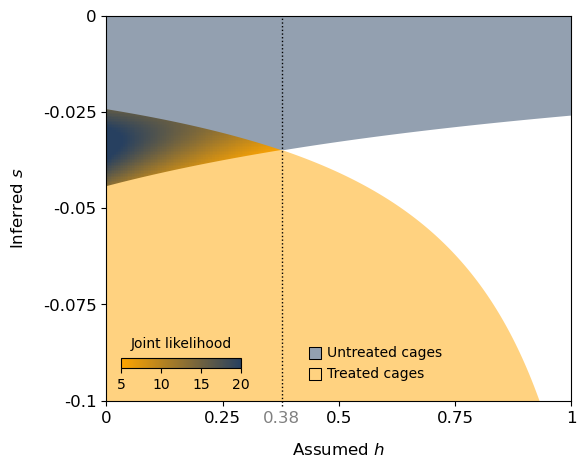

In [25]:
# coloring the overlap by the joint likelihood:

fig = plt.figure(figsize=(6, 5))

# to color the overlap region according to the log likelihood values
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('cmap', [orange, blue])
norm = matplotlib.colors.Normalize(vmin=round(L_min, 0), vmax=round(L_max, 0)) # choosing round values slightly beyond L_min and L_max so that the colorbar looks nicer

filling = plt.pcolormesh(H, S, Ls, cmap=cmap, norm=norm)

plt.fill_between(xs,
                 [inferred_s_control.loc[i]['0.95'][0] if xs[i] >= h_critical else inferred_s.loc[i]['0.95'][1] for i in range(len(xs))], 
                 [inferred_s_control.loc[i]['0.95'][1] for i in range(len(xs))], 
                 color=add_white(blue, 50), alpha=1, linewidth=0)

plt.fill_between(xs,
                 [inferred_s.loc[i]['0.95'][0] for i in range(len(xs))], 
                 [inferred_s.loc[i]['0.95'][1] if xs[i] >= h_critical else inferred_s_control.loc[i]['0.95'][0] for i in range(len(xs))], 
                 color=add_white(orange, 50), alpha=1, linewidth=0)        
        
plt.xticks([0, 0.25, h_critical, 0.5, 0.75,1],
          ['0', '0.25', str(round(h_critical, 2)), '0.5', '0.75', '1'])
plt.xlim(0, 1)    
        
plt.yticks([-0.1, -0.075, -0.05, -0.025, 0],
          ['-0.1', '-0.075', '-0.05', '-0.025', '0'])
plt.ylim(-0.1, 0)     

plt.tick_params(axis='both', labelsize=fontsize)

# coloring the extra tick + label
ax = plt.gca()
tick_labels = ax.get_xticklabels()
for i, label in enumerate(tick_labels):
    if i == 2:
        label.set_color('grey') 
        
plt.plot([h_critical, h_critical], [-0.101, -0.1015], color='#ffffff', linewidth=5, clip_on=False)
plt.plot([h_critical, h_critical], [-0.1015, 0], color='#000000', linewidth=1, linestyle=':', zorder=10, alpha=1, clip_on=False)

# for legend
plt.scatter(-1, 1, marker='s', s=80, edgecolor='#000000', facecolor=add_white(blue, 50), linewidth=0.75, label='Untreated cages')
plt.scatter(-1, 1, marker='s', s=80, edgecolor='#000000', facecolor=add_white(orange, 50), linewidth=0.75, label='Treated cages')
plt.legend(frameon=False, handletextpad=-0.1, bbox_to_anchor=(0, 0.175, 0.75, 0))
     
plt.xlabel('Assumed $h$', fontsize=fontsize, labelpad=padsize);
plt.ylabel('Inferred $s$', fontsize=fontsize, labelpad=padsize);
        
cbar_ax = fig.add_axes([0.15, 0.175, 0.2, 0.02])
cbar = matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, ticks=[0, 5, 10, 15, 20, 25], orientation='horizontal')
filling.set_clim(vmin=5, vmax=20)
cbar.set_label('Joint likelihood', labelpad=-40, y=0.45)

plt.savefig('../figures/inferred_s_h_likelihood.pdf', dpi=600, bbox_inches='tight') 

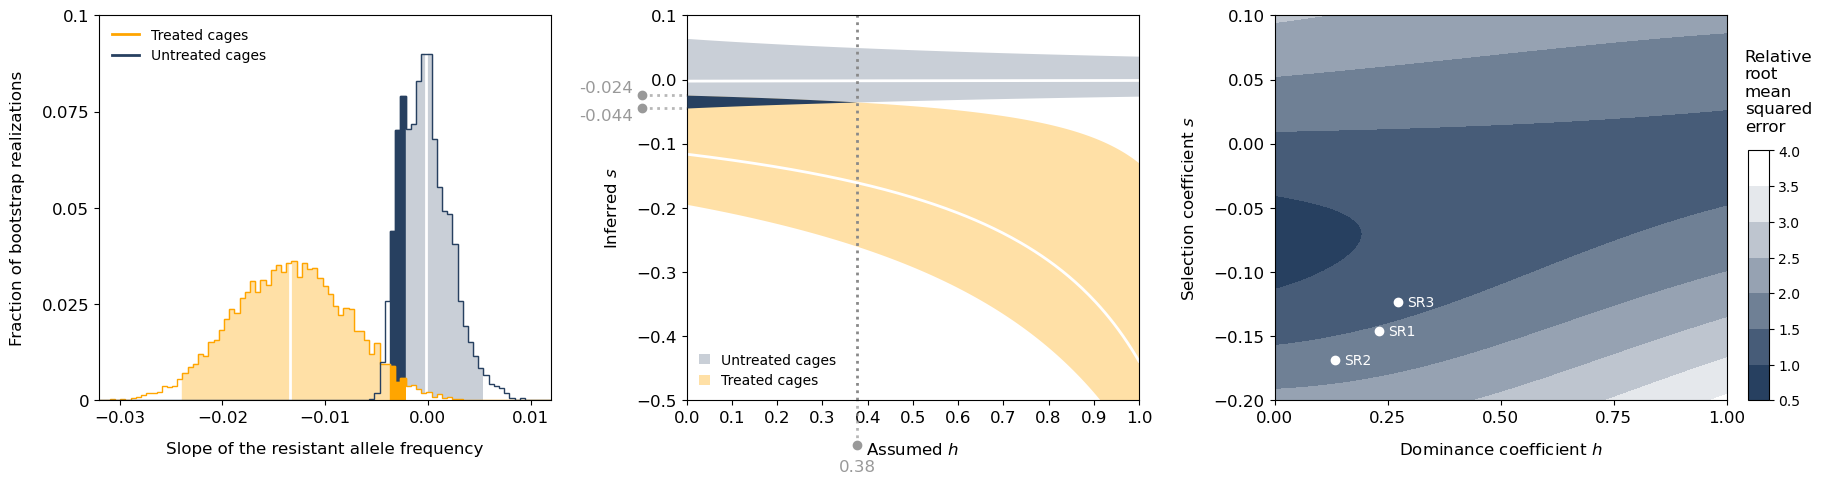

In [26]:
fig = plt.figure(figsize=(21, 5))

grid = gridspec.GridSpec(ncols=3, nrows=1,
                         width_ratios=[1, 1, 1], wspace=0.3,
                         height_ratios=[1], hspace=0)

for d in range(3):
    
    plt.subplot(grid[d // 3, d % 3])
    
    if d == 0: # left panel 

        counts, values, bars = plt.hist([x[0] for x in bootstrapped_slope_intercept_control], bins=np.linspace(-0.035, 0.015, 100), color='#ffffff', alpha=1)
        for j, (count, value, bar) in enumerate(zip(counts, values, bars)):
            if value >= slopes_control['0.95'][0] and value <= slopes_control['0.95'][1]:
                bar.set_color(add_white(blue, 75))
            # finding the overlapping bit:
            if value >= slopes_control['0.95'][0] and value <= slopes['0.95'][1]:
                bar.set_color(blue) 
        
        counts, values, bars = plt.hist([x[0] for x in bootstrapped_slope_intercept], bins=np.linspace(-0.035, 0.015, 100), color='#ffffff', alpha=1)
        for j, (count, value, bar) in enumerate(zip(counts, values, bars)):
            if value >= slopes['0.95'][0] and value <= slopes['0.95'][1]:
                    bar.set_color(add_white(orange, 65))
            # finding the overlapping bit:
            if value >= slopes_control['0.95'][0] and value <= slopes['0.95'][1]:
                bar.set_color(orange)      
                       
        plt.axvline(np.mean([x[0] for x in bootstrapped_slope_intercept]), color=add_white(orange, 100), linewidth=2)
        plt.axvline(np.mean([x[0] for x in bootstrapped_slope_intercept_control]), color=add_white(blue, 100), linewidth=2)

        plt.hist([x[0] for x in bootstrapped_slope_intercept], bins=np.linspace(-0.035, 0.015, 100), histtype='step', alpha=1, edgecolor=orange)
        plt.hist([x[0] for x in bootstrapped_slope_intercept_control], bins=np.linspace(-0.035, 0.015, 100), histtype='step', alpha=1, edgecolor=blue)
        
        # for legend
        plt.axvline(-1, color=orange, linewidth=2, label='Treated cages')
        plt.axvline(1, color=blue, linewidth=2, label='Untreated cages')
        
        plt.legend(frameon=False, fontsize=legendfontsize)

        plt.xlim(-0.032, 0.012)
        plt.ylim(0, 1000)
        plt.yticks([0, 250, 500, 750, 1000], [0, 250 / B, 500 / B, 750 / B, 1000 / B])
        plt.xticks([-0.03, -0.02, -0.01, 0, 0.01])

        plt.tick_params(axis='both', labelsize=fontsize)

        plt.xlabel('Slope of the resistant allele frequency', fontsize=fontsize, labelpad=padsize);
        plt.ylabel('Fraction of bootstrap realizations', fontsize=fontsize, labelpad=padsize);
        
    elif d == 1: # central panel
        
        plt.fill_between(xs,
                         [inferred_s_control.loc[i]['0.95'][0] for i in range(len(xs))], 
                         [inferred_s_control.loc[i]['0.95'][1] for i in range(len(xs))], 
                         color=add_white(blue, 75), alpha=1, linewidth=0, label='Untreated cages')
        
        plt.fill_between(xs,
                         [inferred_s.loc[i]['0.95'][0] for i in range(len(xs))], 
                         [inferred_s.loc[i]['0.95'][1] for i in range(len(xs))], 
                         color=add_white(orange, 65), alpha=1, linewidth=0, label='Treated cages')
        
        plt.fill_between([x for x in xs if x <= h_critical], 
                         [get_s(slopes_control['0.95'][0], f0_control, h) for h in [x for x in xs if x <= h_critical]], 
                         [get_s(slopes['0.95'][1], f0, h) for h in [x for x in xs if x <= h_critical]], 
                         color=blue, alpha=1, linewidth=0, zorder=10)

        
        # plotting the means:
        plt.plot(xs, [inferred_s_control.loc[i]['mean'] for i in range(len(xs))], color=add_white(blue, 100), linewidth=2, alpha=1, zorder=2)
        plt.plot(xs, [inferred_s.loc[i]['mean'] for i in range(len(xs))], color=add_white(orange, 100), linewidth=2, alpha=1, zorder=2)        
        
 
        # annotating the overlap region
        plt.plot([h_critical, h_critical], [-0.57, -0.5], color=grey, linewidth=2, linestyle=':', zorder=2, alpha=0.7, clip_on=False)
        plt.plot([h_critical, h_critical], [-0.5, 0.1], color='#898989', linewidth=2, linestyle=':', zorder=2, alpha=1)
        plt.scatter(h_critical, -0.57, color=grey, clip_on=False)
        plt.text(h_critical, -0.61, str(round(h_critical, 2)), ha='center', color=grey, fontsize=fontsize)
        
        plt.plot([-0.1, 0], [s_min, s_min], color=grey, linewidth=2, linestyle=':', zorder=2, alpha=0.7, clip_on=False)
        plt.plot([-0.1, 0], [s_max, s_max], color=grey, linewidth=2, linestyle=':', zorder=2, alpha=0.7, clip_on=False)
        plt.scatter([-0.1, -0.1], [s_min, s_max], color=grey, clip_on=False)
        plt.text(-0.12, s_min, str(round(s_min, 3)), ha='right', va='top', color=grey, fontsize=fontsize)
        plt.text(-0.12, s_max, str(round(s_max, 3)), ha='right', va='bottom', color=grey, fontsize=fontsize)
       
        plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
        plt.xlim(0, 1)    
        
        plt.yticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1])
        plt.ylim(-0.5, 0.1)
       
        plt.tick_params(axis='both', labelsize=fontsize)
        
        plt.legend(frameon=False, fontsize=legendfontsize, loc='lower left', handlelength=0.75);
    
        plt.xlabel('Assumed $h$', fontsize=fontsize, labelpad=padsize);
        plt.ylabel('Inferred $s$', fontsize=fontsize, labelpad=padsize);
        
    elif d == 2: # right panel
        
        # defining a grid of parameter values 
        hs = np.linspace(0, 1, 100)
        ss = np.linspace(-0.2, 0.1, 200)

        # creating meshgrid
        H, S = np.meshgrid(hs, ss, indexing='ij')    
        errs = np.zeros_like(H, dtype=float)    

        for i in range(H.shape[0]):
            for j in range(H.shape[1]):
                predicted_slope_control = get_slope(f0_control, S[i, j], H[i, j])
                predicted_slope = get_slope(f0, S[i, j], H[i, j])
        
                errs[i, j] = rrmse([slopes_control['mean'], slopes['mean']], [predicted_slope_control, predicted_slope])

        cmap = matplotlib.colors.LinearSegmentedColormap.from_list('cmap', [blue, '#ffffff'])
        norm = matplotlib.colors.Normalize(vmin=min(errs.flatten()), vmax=max(errs.flatten())) 
        
        contour = plt.contourf(H, S, errs, levels=[0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4], cmap=cmap, norm=norm)
        
        # cbar title
        plt.text(1.04, 0.01, 'Relative\nroot\nmean\nsquared\nerror', fontsize=fontsize)

        plt.scatter(h_s_dict[0]['h01'], h_s_dict[0]['s1'], color='#ffffff')
        plt.scatter(h_s_dict[0]['h02'], h_s_dict[0]['s2'], color='#ffffff')
        plt.scatter(h_s_dict[0]['h03'], h_s_dict[0]['s3'], color='#ffffff')
        
        plt.text(h_s_dict[0]['h01'] + 0.05, h_s_dict[0]['s1'], 'SR1', va='center', ha='center', color='#ffffff')
        plt.text(h_s_dict[0]['h02'] + 0.05, h_s_dict[0]['s2'], 'SR2', va='center', ha='center', color='#ffffff')
        plt.text(h_s_dict[0]['h03'] + 0.05, h_s_dict[0]['s3'], 'SR3', va='center', ha='center', color='#ffffff')

        plt.xticks([0, 0.25, 0.5, 0.75, 1])
        plt.yticks([-0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1])
        plt.tick_params(axis='both', labelsize=fontsize)

        plt.xlabel('Dominance coefficient $h$', fontsize=fontsize, labelpad=padsize);
        plt.ylabel('Selection coefficient $s$', fontsize=fontsize, labelpad=padsize);
            
        cbar_ax = plt.gcf().add_axes([0.91, 0.11, 0.01, 0.5]) 
        bar = plt.colorbar(contour, cax=cbar_ax)

plt.savefig('../figures/inferred_s_h.pdf', dpi=600, bbox_inches='tight') 

# saving the output - uncomment if needed 
flat_errs = errs.flatten()
h_values = np.repeat(hs, len(ss)) # repeat each h for each s
s_values = np.tile(ss, len(hs)) # repeat the s values for each h
df = pd.DataFrame({'h': h_values, 's': s_values, 'rrmse': flat_errs})
df.to_csv('../data/errors.csv', index=False)

## Simulating the dynamics of recessive and codominant alleles

In [27]:
def f_t(s, h, f0, T):
    freqs = [f0]
    f = f0
    for t in range(1, T):
        f1 = (f**2*(1+s) + f*(1-f)*(1+h*s)) / (f**2*(1+s) + 2*f*(1-f)*(1+h*s) + (1-f)**2)
        freqs.append(f1)
        f = f1
    return freqs

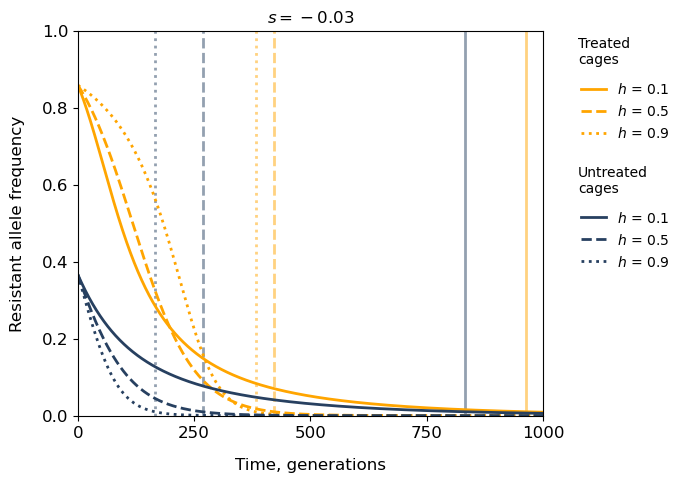

In [28]:
plt.figure(figsize=(6, 5))

# saving the output - uncomment if needed
f_t_h = pd.DataFrame(columns=['f0', 'h, assuming s = -0.03'] + ['t = ' + str(i) for i in range(10001)], index=range(6))
c = 0
for j, freq in enumerate([f0, f0_control]):
    for i, h in enumerate([0.1, 0.5, 0.9]):
        f_t_h.loc[c] = [freq, h] + f_t(-0.03, h, freq, 10001)
        c += 1
f_t_h.to_csv('../data/freq_dynamics_h.csv', index=False) 
    
linestyles = ['solid', 'dashed', 'dotted']    

for i, h in enumerate([0.1, 0.5, 0.9]):
    plt.plot(range(10001), f_t(-0.03, h, f0, 10001), color=orange, linestyle=linestyles[i], linewidth=2, label=f'$h$ = {h}', zorder=-i)
    t_loss = range(10001)[next(i for i, value in enumerate(f_t(-0.03, h, f0, 10001)) if value < 0.01)]
    plt.axvline(t_loss, color=add_white(orange,  50), linestyle=linestyles[i], linewidth=2, zorder=-10)
    
    #print(f'Assuming s = -0.03, h = {h}, it would take {t_loss} gen. to reach 1% freq. starting from f = {round(f0, 2)}')
    
    plt.plot(range(10001), f_t(-0.03, h, f0_control, 10001), color=blue, linestyle=linestyles[i], linewidth=2, label=f'$h$ = {h}', zorder=-i)
    t_loss = range(10001)[next(i for i, value in enumerate(f_t(-0.03, h, f0_control, 10001)) if value < 0.01)]
    plt.axvline(t_loss, color=add_white(blue, 50), linestyle=linestyles[i], linewidth=2, zorder=-10)
    
    #print(f'Assuming s = -0.03, h = {h}, it would take {t_loss} gen. to reach 1% freq. starting from f = {round(f0_control, 2)}')

plt.xlim(1, 1000)
plt.ylim(0, 1)

plt.xticks([0, 250, 500, 750, 1000])
plt.tick_params(axis='both', labelsize=fontsize)

plt.title('$s=-0.03$')

# for legend:
plt.plot([-1, -1], [-1, -1], color='white', alpha=0, label=' ')
plt.plot([-1, -1], [-1, -1], color='white', alpha=0, label=' ')
plt.plot([-1, -1], [-1, -1], color='white', alpha=0, label=' ')

handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 2, 4, 6, 7, 8, 1, 3, 5]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           frameon=False, fontsize=legendfontsize, ncol=1, loc='upper right', 
           bbox_to_anchor=(1.3, 0.9), handlelength=1.82, columnspacing=1);

plt.text(1075, 0.915, 'Treated\ncages', fontsize=legendfontsize)
plt.text(1075, 0.58, 'Untreated\ncages', fontsize=legendfontsize)

plt.xlabel('Time, generations', fontsize=fontsize, labelpad=padsize)
plt.ylabel('Resistant allele frequency', fontsize=fontsize, labelpad=padsize)

plt.savefig('../figures/loss_time.pdf', dpi=600, bbox_inches='tight') 